In [5]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import pytorch_lightning as pl
from pytorch_lightning import Trainer
from pytorch_lightning.loggers import TensorBoardLogger
import torch.nn.functional as F
import sys
import os
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from sklearn.preprocessing import StandardScaler
root = "/project/wyin/jlee/ml-project/dos-prediction"
util_loc = os.path.join(root, "utils")
data_loc = os.path.join(root, "data")
sys.path.append(util_loc)
from utilities import LitNeuralNet, DosDataModule
model_log_path = os.path.join(root, "neural-nets/ensembling/logs")

In [6]:
models = []
same_models = []
for i in range(24):
    log_path = os.path.join(model_log_path, "long-run-24")
    log_dir = os.listdir(log_path)[i]
    check_dir = os.path.join(log_path, log_dir, "version_0/checkpoints")
    check_file = os.listdir(check_dir)[0]
    check_path = os.path.join(check_dir, check_file)
    model = LitNeuralNet.load_from_checkpoint(checkpoint_path=check_path)
    model_name = log_dir.rpartition(']')[0] + ']'
    
    if model_name != "[3, 256, 512, 768, 1024, 301]":
        models.append((model_name, model))
        
    else:
        same_models.append(model)
    
    
for i in range(10):
    log_path = os.path.join(model_log_path, "long-run-10")
    log_dir = os.listdir(log_path)[i]
    check_dir = os.path.join(log_path, log_dir, "version_1/checkpoints")
    check_file = os.listdir(check_dir)[0]
    check_path = os.path.join(check_dir, check_file)
    model = LitNeuralNet.load_from_checkpoint(checkpoint_path=check_path)
    model_name = log_dir.rpartition(']')[0] + ']'
    models.append((model_name, model))
    
print(len(models))
print(len(same_models))

24
10


In [7]:
dataset = np.load(f"{data_loc}/train-set.npz")
train_params = dataset['params']

dataset = np.load(f"{data_loc}/val-set.npz")
val_params_arr = dataset['params']
val_dos_arr = dataset['dos']

scaler = StandardScaler()
scaler.fit(train_params)
val_params_arr = scaler.transform(val_params_arr)

val_params_arr = torch.from_numpy(val_params_arr).float()
val_dos_arr = torch.from_numpy(val_dos_arr).float()
print(val_params_arr.shape)

torch.Size([13265, 3])


In [9]:
def mse(model):
    predicted = model.forward_prop(val_params_arr)
    return F.mse_loss(predicted, val_dos_arr).item()

sorted_models = sorted(models, key = lambda x : mse(x[1]))
best_model = sorted_models[0][1]
print(best_model)

LitNeuralNet(
  (forward_prop): Sequential(
    (0): Linear(in_features=3, out_features=170, bias=True)
    (1): ReLU()
    (2): Linear(in_features=170, out_features=340, bias=True)
    (3): ReLU()
    (4): Linear(in_features=340, out_features=510, bias=True)
    (5): ReLU()
    (6): Linear(in_features=510, out_features=680, bias=True)
    (7): ReLU()
    (8): Linear(in_features=680, out_features=850, bias=True)
    (9): ReLU()
    (10): Linear(in_features=850, out_features=1020, bias=True)
    (11): ReLU()
    (12): Linear(in_features=1020, out_features=301, bias=True)
  )
)


In [10]:
#Predictions by single best model
single_pred = best_model.forward_prop(val_params_arr).detach().numpy()

#Predictions by ensemble
total_pred = torch.zeros([13265, 301])
total_mse = 0
for model_name, model in sorted_models[:8]:
    predicted = model.forward_prop(val_params_arr)
    error = mse(model)
    total_mse += error
    total_pred = torch.add(total_pred, predicted)

avg_pred = total_pred / 8
ens_mse = F.mse_loss(avg_pred, val_dos_arr).item()
avg_pred = avg_pred.detach().numpy()

val_dos = val_dos_arr.numpy()

In [28]:
single_mse_mat = (val_dos - single_pred) ** 2
single_mse_list = np.mean(single_mse_mat, axis = 1)

mse_dos = list(zip(single_mse_list, single_pred, avg_pred, val_dos))
print(val_dos.shape)
mse_dos = sorted(mse_dos, key = lambda x : x[0], reverse = True)
num_dos = len(mse_dos)

(13265, 301)


In [80]:
def plot_one(idx, ax, title, mode):
    ax.plot(np.linspace(-6, 6, 301), mse_dos[idx][mode], label = 'NN predicted', alpha = 0.5)
    ax.plot(np.linspace(-6, 6, 301), mse_dos[idx][3], label = 'Ground Truth', alpha = 0.5)
    ax.legend()
    ax.set_title(title)
    ax.text(0, 0.3, mse_dos[idx][0])

Text(0, 0.3, '5.0490917e-07')

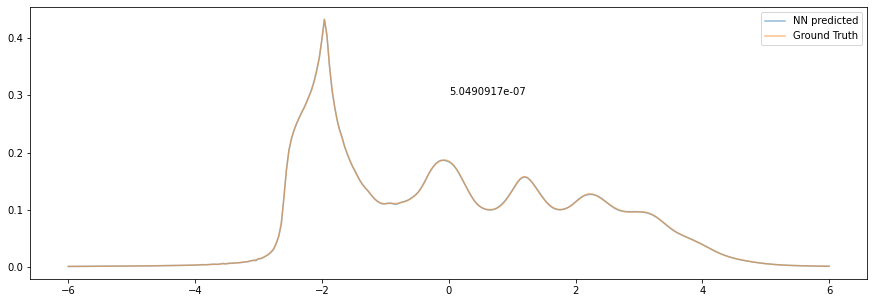

In [79]:
#Random test plot
idx = 13100
fig, ax = plt.subplots(figsize = (15, 5))
ax.plot(np.linspace(-6, 6, 301), mse_dos[idx][1], label = 'NN predicted', alpha = 0.5)
ax.plot(np.linspace(-6, 6, 301), mse_dos[idx][3], label = 'Ground Truth', alpha = 0.5)
ax.legend()
ax.text(0, 0.3, mse_dos[idx][0])

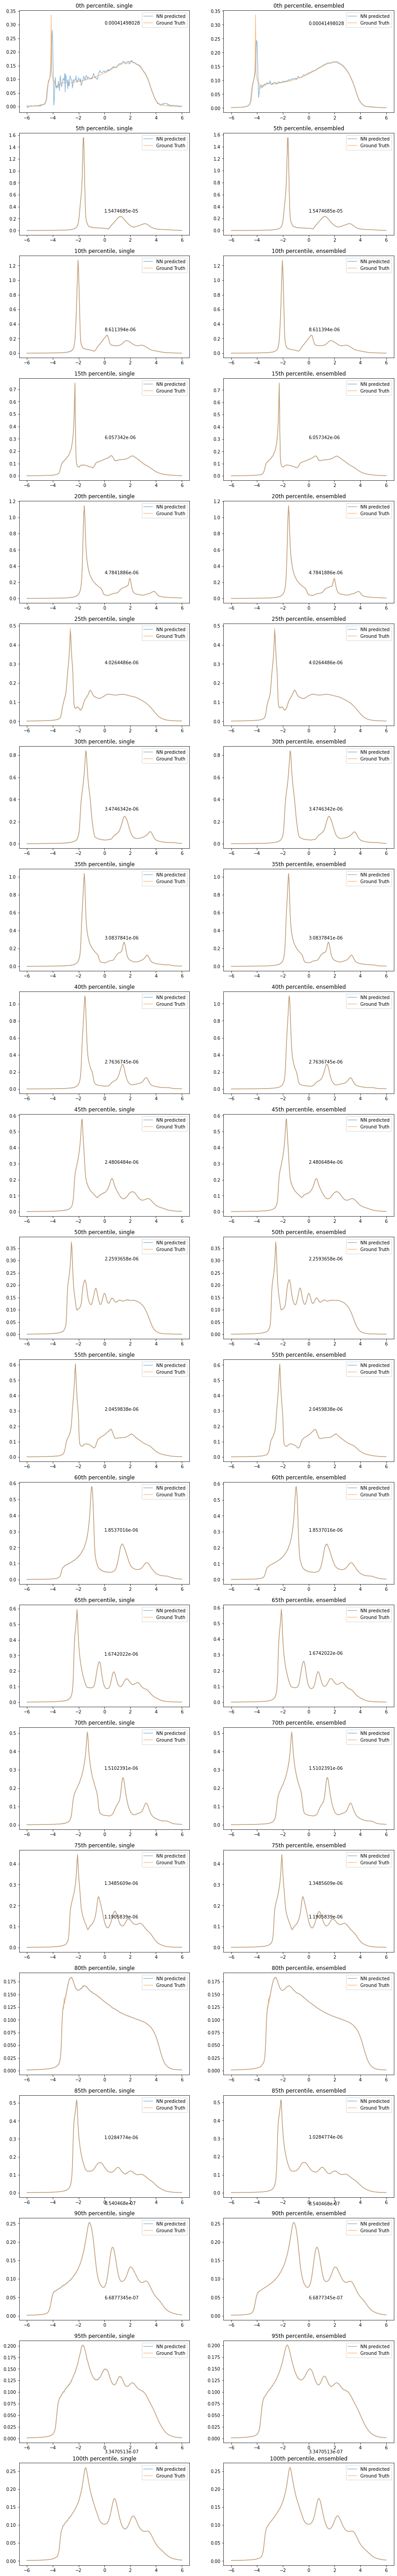

In [43]:
fig, ax = plt.subplots(21, 2, figsize = (15, 105))
for i in range(21):
    plot_one(i * (num_dos // 20), ax[i][0], f"{5 * i}th percentile, single", 1)
    plot_one(i * (num_dos // 20), ax[i][1], f"{5 * i}th percentile, ensembled", 2)

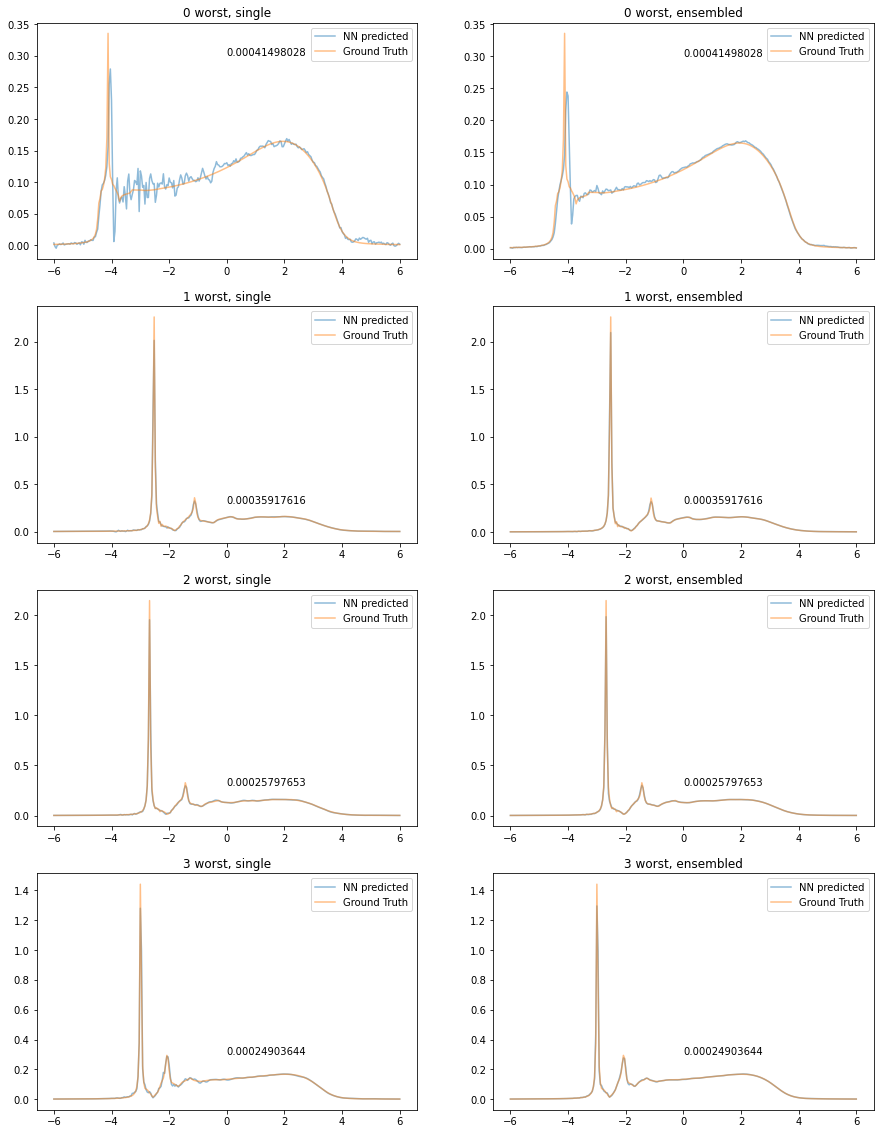

In [81]:
#10 worst models
fig, ax = plt.subplots(4, 2, figsize = (15, 20))
for i in range(4):
    plot_one(i, ax[i][0], f"{i} worst, single", 1)
    plot_one(i, ax[i][1], f"{i} worst, ensembled", 2)

In [ ]:
#Average standard deviation per point in the validation set

#Get all separate model predictions as matrix
for model_name, model in sorted_models[:8]:
    predicted = model.forward_prop(val_params_arr)
    error = mse(model)
    total_mse += error
    total_pred = torch.add(total_pred, predicted)

avg_pred = total_pred / 8
ens_mse = F.mse_loss(avg_pred, val_dos_arr).item()
avg_pred = avg_pred.detach().numpy()
 